# All needed imports

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.layers import Input, Conv2D, Reshape, UpSampling2D, MaxPool2D, Dense, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [3]:
sess = tf.Session()
K.set_session(sess)

# Load dataset

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test,  (len(x_test),  28, 28, 1))

y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)

In [5]:
batch_size = 500
latent_dim = 49
dropout_rate = 0.3
start_lr = 0.0001

## ENCODER

In [8]:
from keras.layers import BatchNormalization, Dropout, Lambda
from keras.objectives import binary_crossentropy


input_vae_encoder = Input(batch_shape=(batch_size, 28, 28, 1))

with tf.variable_scope('vae_encoder'):
    x = Conv2D(32, kernel_size=(5, 5))(input_vae_encoder)
    x = LeakyReLU()(x)    
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Conv2D(16, kernel_size=(5, 5))(x)
    x = LeakyReLU()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    begin_of_dense = Flatten()(x)
    x = LeakyReLU()(begin_of_dense)
    x = Dense(latent_dim * 4)(x)
    x = LeakyReLU()(x)
    
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
vae_encoder = Model(input_vae_encoder, l, name="Encoder")
z_meaner = Model(input_vae_encoder, z_mean, name="ZMeaner")
z_log_varer = Model(input_vae_encoder, z_log_var, name="ZLogVarer")

# vae_encoder.compile(loss='binary_crossentropy', optimizer='adam')
# vae_encoder.summary()

## DECODER

In [11]:
input_vae_decoder = Input(shape=(latent_dim,))

x = Dense(latent_dim)(input_vae_decoder)
x = Reshape(target_shape=(7, 7, 1))(x)
x = Conv2D(16, kernel_size=(7, 7), padding='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(32, kernel_size=(5, 5), padding='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D(size=(2, 2))(x)
decoded = Conv2D(1, kernel_size=(7, 7), padding='same', activation='sigmoid')(x)
vae_decoder = Model(input_vae_decoder, decoded, name='Decoder')

In [12]:
vae_model = Model(input_vae_encoder, vae_decoder(vae_encoder(input_vae_encoder)), name="ConvVAE")

In [13]:
def vae_loss(x, decoded):
    x = K.reshape(x, shape=(batch_size, 28 * 28 * 1))
    decoded = K.reshape(decoded, shape=(batch_size, 28 * 28 * 1))
    xent_loss = 28 * 28 * binary_crossentropy(x, decoded)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return (xent_loss + kl_loss) / 2 / 28 / 28

In [16]:
from keras.optimizers import Adam


vae_model.compile(loss=vae_loss, optimizer=Adam(start_lr))
vae_model.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (500, 28, 28, 1)          0         
_________________________________________________________________
Encoder (Model)              (500, 8)                  22400     
_________________________________________________________________
Decoder (Model)              multiple                  15642     
Total params: 38,042
Trainable params: 38,042
Non-trainable params: 0
_________________________________________________________________


In [17]:
digit_size = 28

def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    plt.figure(figsize=(2*n, 2*len(args)))
    plt.imshow(figure, cmap='Greys_r')
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 60000 samples, validate on 10000 samples


Epoch 1/100
60000/60000 [==============================] - 12s 197us/step - loss: 0.2641 - val_loss: 0.1877


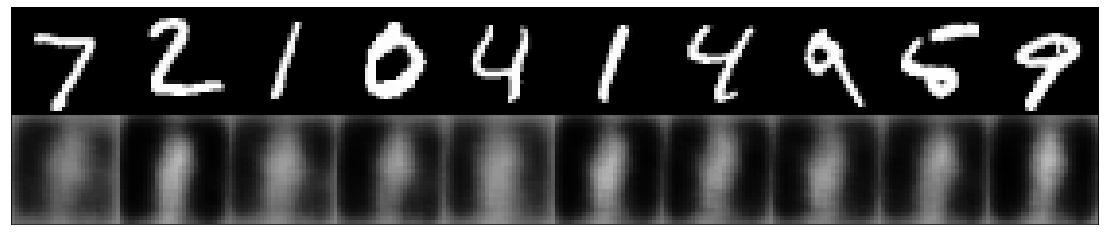


Epoch 2/100
60000/60000 [==============================] - 8s 128us/step - loss: 0.1651 - val_loss: 0.1487
Epoch 3/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.1404 - val_loss: 0.1335
Epoch 4/100
60000/60000 [==============================] - 8s 128us/step - loss: 0.1285 - val_loss: 0.1226
Epoch 5/100
60000/60000 [==============================] - 8s 128us/step - loss: 0.1185 - val_loss: 0.1142
Epoch 6/100
60000/60000 [==============================] - 8s 128us/step - loss: 0.1123 - val_loss: 0.1095
Epoch 7/100
60000/60000 [==============================] - 8s 128us/step - loss: 0.1084 - val_loss: 0.1060
Epoch 8/100
60000/60000 [==============================] - 8s 128us/step - loss: 0.1052 - val_loss: 0.1029
Epoch 9/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.1023 - val_loss: 0.1002
Epoch 10/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.0998 - val_loss: 0.0979
Epoch 11/100
60000/60000 [=========

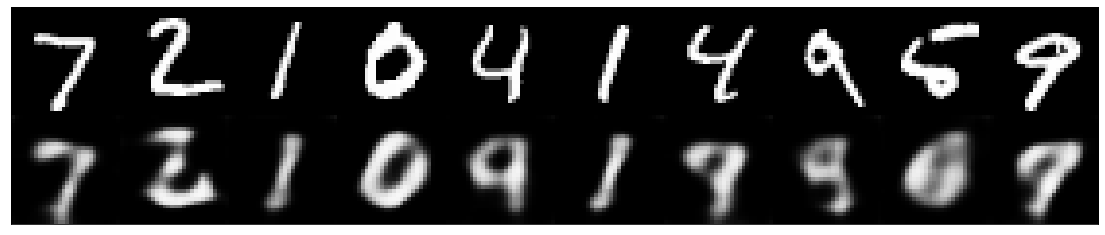

Epoch 13/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.0948 - val_loss: 0.0933
Epoch 14/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.0936 - val_loss: 0.0923
Epoch 15/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.0926 - val_loss: 0.0913
Epoch 16/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.0917 - val_loss: 0.0905
Epoch 17/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.0909 - val_loss: 0.0897
Epoch 18/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.0901 - val_loss: 0.0890
Epoch 19/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.0895 - val_loss: 0.0885
Epoch 20/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.0889 - val_loss: 0.0879
Epoch 21/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0883 - val_loss: 0.0874
Epoch 22/100
60000/60000 [==

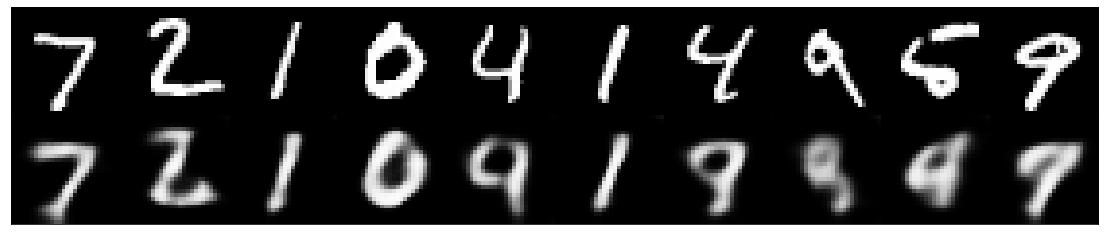

Epoch 24/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0869 - val_loss: 0.0859
Epoch 25/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0864 - val_loss: 0.0855
Epoch 26/100
60000/60000 [==============================] - 8s 131us/step - loss: 0.0860 - val_loss: 0.0851
Epoch 27/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0857 - val_loss: 0.0848
Epoch 28/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0853 - val_loss: 0.0844
Epoch 29/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0850 - val_loss: 0.0841
Epoch 30/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0846 - val_loss: 0.0838
Epoch 31/100
60000/60000 [==============================] - 8s 131us/step - loss: 0.0844 - val_loss: 0.0836
Epoch 32/100
60000/60000 [==============================] - 8s 131us/step - loss: 0.0841 - val_loss: 0.0833
Epoch 33/100
60000/60000 [==

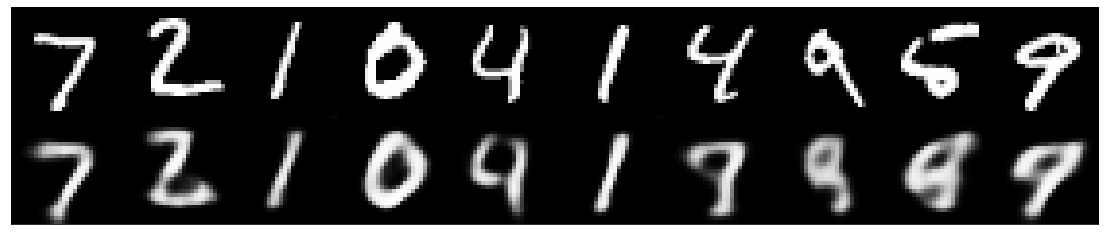

Epoch 35/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0833 - val_loss: 0.0825
Epoch 36/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0831 - val_loss: 0.0823
Epoch 37/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0829 - val_loss: 0.0822
Epoch 38/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0827 - val_loss: 0.0819
Epoch 39/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0825 - val_loss: 0.0817
Epoch 40/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0823 - val_loss: 0.0815
Epoch 41/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0821 - val_loss: 0.0813
Epoch 42/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0819 - val_loss: 0.0811
Epoch 43/100
60000/60000 [==============================] - 8s 131us/step - loss: 0.0818 - val_loss: 0.0810
Epoch 44/100
60000/60000 [==

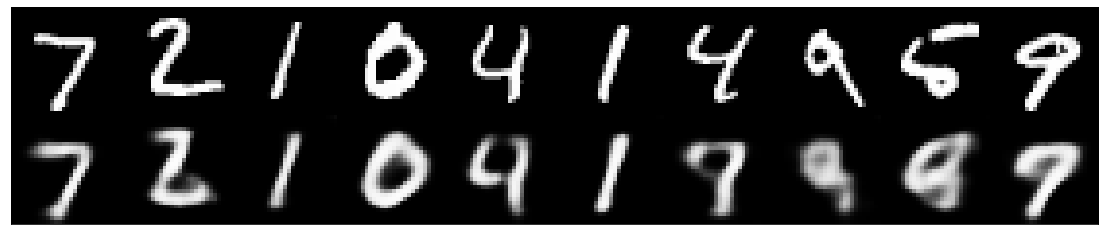

Epoch 46/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0813 - val_loss: 0.0806
Epoch 47/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.0812 - val_loss: 0.0805
Epoch 48/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.0810 - val_loss: 0.0804
Epoch 49/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0809 - val_loss: 0.0802
Epoch 50/100
60000/60000 [==============================] - 8s 132us/step - loss: 0.0808 - val_loss: 0.0801
Epoch 51/100
60000/60000 [==============================] - 8s 131us/step - loss: 0.0807 - val_loss: 0.0799
Epoch 52/100
60000/60000 [==============================] - 8s 131us/step - loss: 0.0805 - val_loss: 0.0800
Epoch 53/100
60000/60000 [==============================] - 8s 131us/step - loss: 0.0804 - val_loss: 0.0798
Epoch 54/100
60000/60000 [==============================] - 8s 131us/step - loss: 0.0803 - val_loss: 0.0796
Epoch 55/100
60000/60000 [==

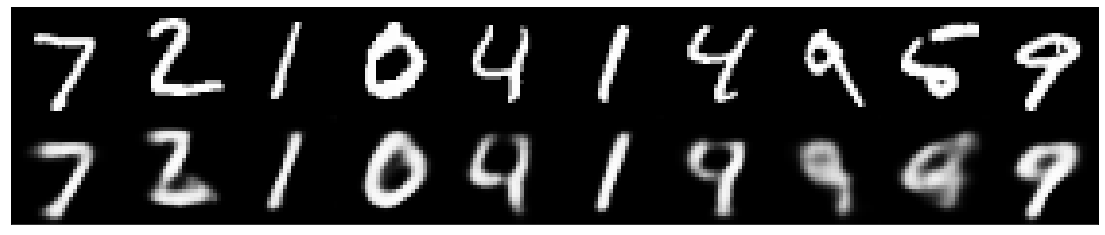

Epoch 57/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.0800 - val_loss: 0.0793
Epoch 58/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.0799 - val_loss: 0.0792
Epoch 59/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.0798 - val_loss: 0.0791
Epoch 60/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0797 - val_loss: 0.0790
Epoch 61/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.0796 - val_loss: 0.0789
Epoch 62/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.0795 - val_loss: 0.0788
Epoch 63/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.0794 - val_loss: 0.0787
Epoch 64/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0793 - val_loss: 0.0787
Epoch 65/100
60000/60000 [==============================] - 8s 131us/step - loss: 0.0792 - val_loss: 0.0785
Epoch 66/100
60000/60000 [==

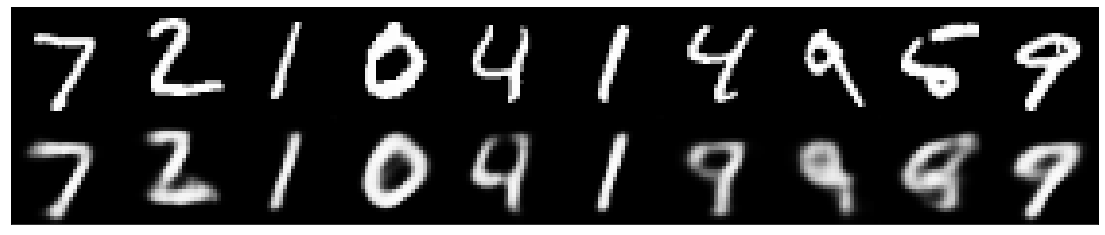

Epoch 68/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0790 - val_loss: 0.0783
Epoch 69/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0789 - val_loss: 0.0782
Epoch 70/100
60000/60000 [==============================] - 8s 132us/step - loss: 0.0788 - val_loss: 0.0781
Epoch 71/100
60000/60000 [==============================] - 8s 134us/step - loss: 0.0787 - val_loss: 0.0781
Epoch 72/100
60000/60000 [==============================] - 8s 131us/step - loss: 0.0787 - val_loss: 0.0780
Epoch 73/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.0786 - val_loss: 0.0780
Epoch 74/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.0785 - val_loss: 0.0778
Epoch 75/100
60000/60000 [==============================] - 8s 131us/step - loss: 0.0784 - val_loss: 0.0778
Epoch 76/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.0784 - val_loss: 0.0778
Epoch 77/100
60000/60000 [==

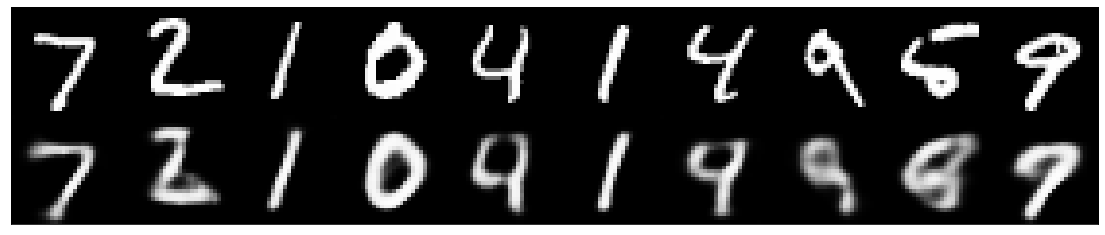

Epoch 79/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0782 - val_loss: 0.0775
Epoch 80/100
60000/60000 [==============================] - 8s 131us/step - loss: 0.0781 - val_loss: 0.0776
Epoch 81/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0781 - val_loss: 0.0774
Epoch 82/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0780 - val_loss: 0.0774
Epoch 83/100
60000/60000 [==============================] - 8s 131us/step - loss: 0.0779 - val_loss: 0.0773
Epoch 84/100
60000/60000 [==============================] - 8s 132us/step - loss: 0.0779 - val_loss: 0.0772
Epoch 85/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0778 - val_loss: 0.0772
Epoch 86/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.0777 - val_loss: 0.0771
Epoch 87/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0777 - val_loss: 0.0770
Epoch 88/100
60000/60000 [==

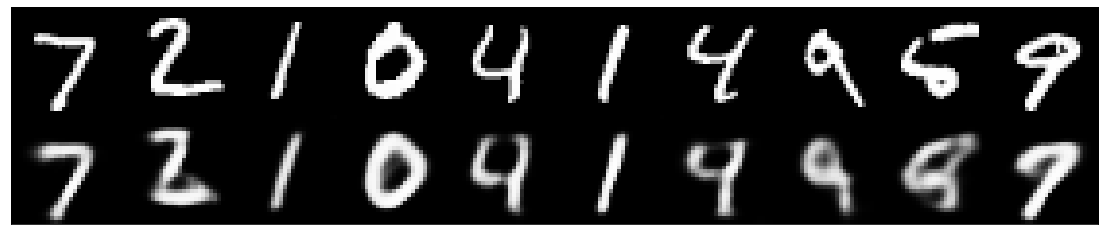

Epoch 90/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.0775 - val_loss: 0.0768
Epoch 91/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0775 - val_loss: 0.0769
Epoch 92/100
60000/60000 [==============================] - 8s 131us/step - loss: 0.0774 - val_loss: 0.0768
Epoch 93/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0774 - val_loss: 0.0768
Epoch 94/100
60000/60000 [==============================] - 8s 131us/step - loss: 0.0773 - val_loss: 0.0767
Epoch 95/100
60000/60000 [==============================] - 8s 131us/step - loss: 0.0773 - val_loss: 0.0767
Epoch 96/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0772 - val_loss: 0.0766
Epoch 97/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0772 - val_loss: 0.0766
Epoch 98/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.0771 - val_loss: 0.0765
Epoch 99/100
60000/60000 [==

In [19]:
from keras.callbacks import LambdaCallback, TensorBoard

epochs_to_check = np.linspace(0, 100, num=10).astype('int')

imgs = x_test[:batch_size]
n_compare = 10


def on_epoch_end(epoch, logs):
    if epoch in epochs_to_check:
        decoded = vae_model.predict(imgs, batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])

        
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)
tb     = TensorBoard(log_dir='./logs')

vae_model.fit(x_train, x_train,
              shuffle=True,
              epochs=100,
              batch_size=batch_size,
              validation_data=(x_test, x_test),
              callbacks=[pltfig, tb],
              verbose=1)

### Try to decode random codes

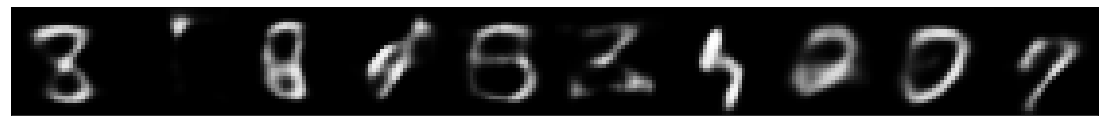

In [23]:
codes = np.random.randn(n_compare, latent_dim)
decoded_from_codes = vae_decoder.predict(codes, batch_size=n_compare)
plot_digits(decoded_from_codes)

## Save models

In [24]:
import os
import json

save_path = os.path.join("saved_models", "convolutional_vae")
if not os.path.exists(save_path):
    os.mkdir(save_path)

with open(os.path.join(save_path, "vae.json"), "w") as f:
    json.dump(vae_model.to_json(), f, indent=4)
vae_model.save_weights(os.path.join(save_path, "vae.h5"))

with open(os.path.join(save_path, "vae_encoder.json"), "w") as f:
    json.dump(vae_encoder.to_json(), f, indent=4)
vae_encoder.save_weights(os.path.join(save_path, "vae_encoder.h5"))

with open(os.path.join(save_path, "z_meaner.json"), "w") as f:
    json.dump(z_meaner.to_json(), f, indent=4)
z_meaner.save_weights(os.path.join(save_path, "z_meaner.h5"))

with open(os.path.join(save_path, "z_log_varer.json"), "w") as f:
    json.dump(z_log_varer.to_json(), f, indent=4)
z_log_varer.save_weights(os.path.join(save_path, "z_log_varer.h5"))

with open(os.path.join(save_path, "vae_decoder.json"), "w") as f:
    json.dump(vae_decoder.to_json(), f, indent=4)
vae_decoder.save_weights(os.path.join(save_path, "vae_decoder.h5"))